<a href="https://colab.research.google.com/github/marreapato/Deep_Learning_Course/blob/main/C%C3%B3pia_de_Baseline_Projeto.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Tentando Aplicar o Shap

In [ ]:
import yfinance as yf
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, LSTM, GRU
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error

# Download data for the stock (I'm using the Bovespa index as an example)
data = yf.download('^BVSP', '2007-01-01', '2023-10-17')
data = data[['Close']]

# Normalize the data
scaler = MinMaxScaler()
data['Close'] = scaler.fit_transform(data['Close'].values.reshape(-1, 1))

# Define a function to create lag features
def create_lagged_dataset(dataset, look_back=1):
    X, Y = [], []
    for i in range(len(dataset) - look_back):
        a = dataset[i:(i + look_back), 0]
        X.append(a)
        Y.append(dataset[i + look_back, 0])
    return np.array(X), np.array(Y)

# Split the data into train and test sets
train_size = int(len(data) * 0.75)
test_size = len(data) - train_size
train, test = data[0:train_size], data[train_size:len(data)]

# Create lag features for the models
look_back = 5  # Adjust this as needed
trainX, trainY = create_lagged_dataset(train.values, look_back)
testX, testY = create_lagged_dataset(test.values, look_back)

# Reshape the input data for LSTM and GRU models
trainX = np.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
testX = np.reshape(testX, (testX.shape[0], 1, testX.shape[1]))

# Define the GRU model
def GRU_Model(output_window):
    model = Sequential()
    model.add(GRU(128, return_sequences=False, input_shape=(1, look_back)))
    model.add(Dense(output_window))
    model.compile(optimizer='adam', loss='mean_squared_error')
    return model

# Define the LSTM model
def LSTM_Model(output_window):
    model = Sequential()
    model.add(LSTM(128, return_sequences=False, input_shape=(1, look_back)))
    model.add(Dense(output_window))
    model.compile(optimizer='adam', loss='mean_squared_error')
    return model

# Define the baseline model
def baseline_model(output_window):
    last_known_value = trainY[-1]
    return np.full((len(testY), output_window), last_known_value)

# Train and evaluate the models
output_window = 1
gru_model = GRU_Model(output_window)
lstm_model = LSTM_Model(output_window)

gru_model.fit(trainX, trainY, epochs=10, batch_size=64)
lstm_model.fit(trainX, trainY, epochs=10, batch_size=64)

gru_predictions = gru_model.predict(testX)
lstm_predictions = lstm_model.predict(testX)
baseline_predictions = baseline_model(output_window)

# Inverse transform the predictions
gru_predictions = scaler.inverse_transform(gru_predictions)
lstm_predictions = scaler.inverse_transform(lstm_predictions)
baseline_predictions = scaler.inverse_transform(baseline_predictions)



[*********************100%%**********************]  1 of 1 completed



A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Epoch 1/10
49/49 [==============================] - 2s 4ms/step - loss: 0.0167
Epoch 2/10
49/49 [==============================] - 0s 4ms/step - loss: 0.0013
Epoch 3/10
49/49 [==============================] - 0s 4ms/step - loss: 3.9061e-04
Epoch 4/10
49/49 [==============================] - 0s 4ms/step - loss: 1.9241e-04
Epoch 5/10
49/49 [==============================] - 0s 4ms/step - loss: 1.7064e-04
Epoch 6/10
49/49 [==============================] - 0s 4ms/step - loss: 1.6941e-04
Epoch 7/10
49/49 [==============================] - 0s 4ms/step - loss: 1.6847e-04
Epoch 8/10
49/49 [==============================] - 0s 4ms/step - loss: 1.6604e-04
Epoch 9/10
49/49 [==============================] - 0s 4ms/step - loss: 1.6501e-04
Epoch 10/10
49/49 [==============================] - 0s 4ms/step - loss: 1.6390e-04
Epoch 1/10
49/49 [==============================] - 3s 4ms/step - loss: 0.0245
Epoch 2/10
49/49 [==============================] - 0s 4ms/step - loss: 0.0016
Epoch 3/10
49/49 [=

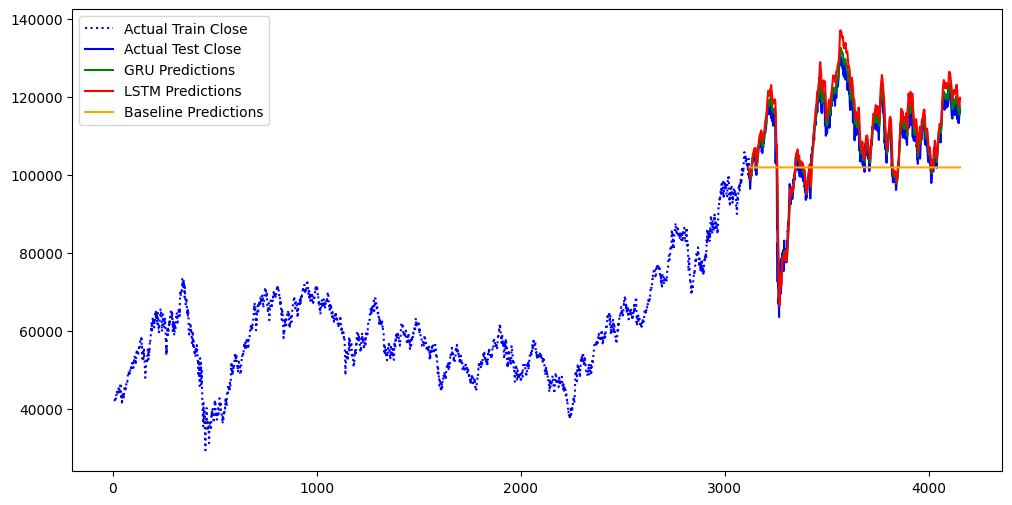

In [ ]:
 #Inverse transform both train and test data
trainY = scaler.inverse_transform(trainY.reshape(-1, 1))
testY = scaler.inverse_transform(testY.reshape(-1, 1))

# Create a time index for plotting
time_index_train = range(len(data) - len(testY) - len(trainY), len(data) - len(testY))
time_index_test = range(len(data) - len(testY), len(data))

# Plot all true values and the predictions with different colors
plt.figure(figsize=(12, 6))
plt.plot(time_index_train, trainY, label='Actual Train Close', color='blue', linestyle='dotted')
plt.plot(time_index_test, testY, label='Actual Test Close', color='blue')
plt.plot(time_index_test, gru_predictions, label='GRU Predictions', color='green')
plt.plot(time_index_test, lstm_predictions, label='LSTM Predictions', color='red')
plt.plot(time_index_test, baseline_predictions, label='Baseline Predictions', color='orange')
plt.legend()
plt.show()

In [ ]:
# Calculate the mean squared error for each model
gru_mse = mean_squared_error(testY, gru_predictions)
lstm_mse = mean_squared_error(testY, lstm_predictions)
baseline_mse = mean_squared_error(testY, baseline_predictions)

# Compare the models using Mean Squared Error
print("GRU Model RMSE: ", np.sqrt(gru_mse))
print("LSTM Model RMSE: ", np.sqrt(lstm_mse))
print("Baseline Model RMSE: ", np.sqrt(baseline_mse))


GRU Model RMSE:  2613.0712419339748
LSTM Model RMSE:  4088.9767145028513
Baseline Model RMSE:  12884.86632386043


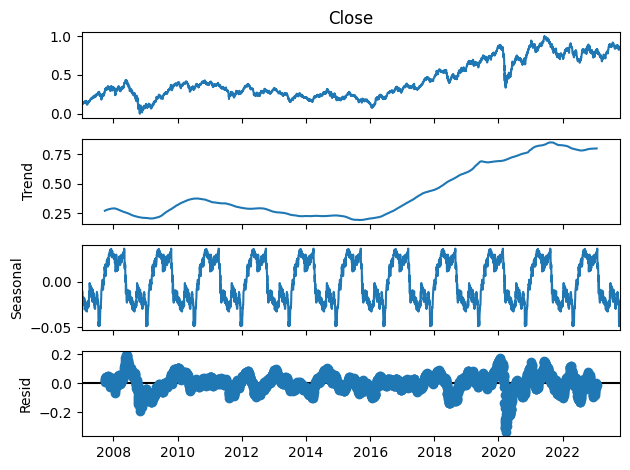

In [ ]:
from statsmodels.tsa.seasonal import seasonal_decompose
result = seasonal_decompose(data['Close'], model='additive',period=365)
result.plot()
plt.show()

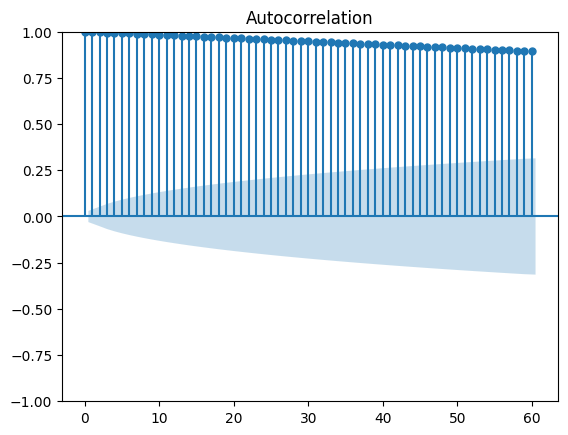

In [ ]:
from statsmodels.graphics.tsaplots import plot_acf
plot_acf(data['Close'], lags=60)
plt.show()

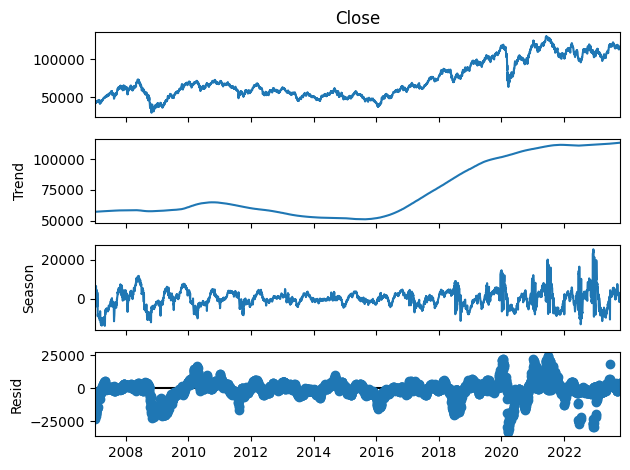

In [ ]:
from statsmodels.tsa.seasonal import STL
stl = STL(data['Close'], period=365,robust=True)#looking for pattern that repeats annualy
res = stl.fit()
fig = res.plot()